# Training a Neural Network with Gradient Tape and TF Datasets

Training a network with ```model.fit()``` is very convenient, as it allows us to trigger
the training with just one call. Adding callbacks to the training also allows us
to interact with the training and create checkpoints or log-files or add a custom callback.

However, in some cases, we may want to have more control over the training loop or have
access to the gradients computed during the training process.

In the examples discussed here, we often use the [Iris dataset](http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)
to illustrate the general principles.
However, in more realistic scenarios, we will need to use much larger datasets which we may 
have to pre-process or transform. Quite often, the dataset will also be larger
than what we can conveniently handle in memory - if we load a dataset, we also need to reserve
the memory to pass it to the training loop, etc.
To ease operational aspects, TensorFlow provides the [```Dataset```](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)
functionality to build [data pipelines](https://www.tensorflow.org/guide/data).
For example, this allows us to define which data we are going to use without reading in all data first - 
TensorFlow will then take care of loading the data as required.

In this example we will
   * write a custom training loop instead of using ```model.fit()```
   * use ```tf.Dataset``` to handle the training data.

For simplicity, we will use again the Iris dataset, but transform it into a ```tf.Dataset``` for training.


In [ ]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix

%pylab inline
# large figures
rcParams['figure.figsize'] = 8, 6
print(tf.__version__)

Populating the interactive namespace from numpy and matplotlib
2.1.0


In [ ]:
iris = load_iris()

### Define the Neural Network

In this example we will use a very simple neural network.
The input layer has 4 nodes, corresponding to the 4 feature variables in each row of the dataset.
The output layer has 3 nodes, corresponding to the 3 types of iris flowers we want to identify.

We then use two hidden layers with 10 nodes each - we could also use different settings, e.g. only one layer or more than two layers with different numbers of hidden nodes. The best setup depends on the problem we wish to analyze.

The main way to build models in Keras is to "stack" layers on top of each other: this is
done in the ```tf.keras.Sequential()``` model.

We will use ReLU as an activation function.
Note that we have specified the shape in the first network layer so the model knows what to expect
when we pass the data to it.

In [ ]:
n_input = 4
n_output = 3
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(n_input,)))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(n_output))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


## Training Setup

We now need to define the ingredients we need for the training:

* The loss function: This determines how the training process should evaluate whether the prediction made by the model is correct or not. As we have categorical data (three types of iris flowers) which we wish to classify, we use the [sparse categorical cross entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)
* The optimizer. Several choices exist, as a good practice, the Adam optimizer (see the [paper](https://arxiv.org/abs/1412.6980)
and the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) for more details) is a good starting point
* The gradients: This is how will determine how to optimize the models of the parameters. Previously, this was handled inside  ```model.fit()```, but as we now build a custom training loop, we need to specify how to optimize the network weights ourselves. In our case, the gradient depends on the loss function (which determines how to tell a right prediction from a wrong one) and the model parameters (which need to be optimized)

### Loss Function
We start with defining a custom loss function. As we focus on a classification task, we use the cross-entropy. For convenience,
we use the implementation provided by Keras for calculating the cross-entropy, though we could implement our own.
However, we do need to implement the loss function itself, which evaluates how the predictions compare
to the true values.

The function ```loss(model, x,y)``` below takes three arguments:
   * ```x```: the features of the training data
   * ```y```: the true labels of the training data
   * ```model```: the model we wish to evaluate.
   
Inside the function, the variable ```y_hat``` signifies the prediction made with the current state of the model.



In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss(model, x, y):
  y_hat = model(x)
  return loss_object(y_true=y, y_pred=y_hat)

### Optimizer

We use the Adam optimizer with a small constant learning rate.


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

### Gradient

We now need to define the gradient that needs to be evaluated during training.
Remember that network training via backpropagation is essentially following a
(complicated) slope of the loss (or error or cost) function. 
In order to calculate this slope, we need to compute the gradient of the loss
function. TensorFlow can do this automatically ("auto-diff") via [```GradientTape```](https://www.tensorflow.org/api_docs/python/tf/GradientTape).

The "Gradient" refers to the functionality of computing the gradient, the "Tape" indicates that the operations and results
are recorded so that we can access them later.

The gradient itself is computed via a call to the ```gradient``` method; higher order derivatives can be obtained by subsequent
calls to this method. 
In order to compute the gradient of the loss function, we pass the current value of the loss function
as well as all (trainable) variables of the model, i.e. the network weights. Note that, in some cases,
we do not allow all parts of the model to be changed during training, hence the distinction to pass all trainable parameters only.

In [ ]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

### Training Data

We now convert the training data into a TensorFlow [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) which provides
convenient functionality for building dataflow pipelines.

In this case we use the following
   * We set the batch size to 32 records, i.e. we consider 32 records at a time during training. More details [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch)
   * We also automatically shuffle the order of the training records during each iterations to avoid the risk that the network learns any specific aspects that are related to the order in which the records are presented to the network. More details [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle)


In [ ]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((iris.data, iris.target)).batch(batch_size).shuffle(10000)

## Network Training



The main part of the training loop is to run over the dataset, compute the loss function and the gradient, and then optimize the parameters.
As we have defined the TensorFlow dataset above, the data are accessed in batches of 32 samples at the time.
Hence the core part is:
```
for i in range(250):
     for x,y in train_dataset:
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
```

In addition, we want to log the values of the loss function and the current accuracy (on the training sample) at each step of the training for later analysis. The rest of the loop below saves this information. Since we train the network in batches of 32 samples in each training iteration, we average over the values in each batch to smooth out some statistical fluctuations.
(Note: ideally we would also include the loss and accuracy of an independent test sample during training).

We then need to pass the computed gradient to the optimizer so that the optimizer can change the variable values accordingly.

In [ ]:
training_loss = []
training_acc  = []

for i in range(250):
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    mean_loss = tf.keras.metrics.Mean()
    
    for x,y in train_dataset:
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
        accuracy(y, model(x))
        mean_loss(loss_value)

    training_loss.append(mean_loss.result())
    training_acc.append(accuracy.result())

    if i%50 == 0:
        print("Iteration {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(i,
                                                                    mean_loss.result(),
                                                                    accuracy.result()))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Iteration 000: Loss: 1.782, Accuracy: 33.333%
Iteration 050: Loss: 0.162, Accuracy: 98.000%
Iteration 100: Loss: 0.105, Accuracy: 96.667%
Iteration 150: Loss: 0.082, Accuracy: 98.000%
Iteration 200: Loss: 0.164, Accuracy: 94.667%


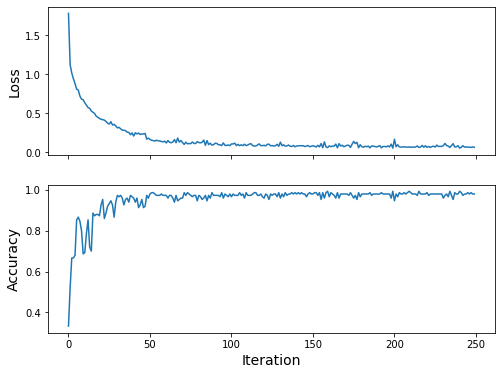

In [ ]:
fig, axes = plt.subplots(2, sharex=True)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(training_loss)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Iteration", fontsize=14)
axes[1].plot(training_acc)
plt.show()

## Predictions

In [ ]:
predictions=model(iris.data)
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(iris.target))

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
    Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
